In [3]:
%uv pip install wandb pycocotools kagglehub huggingface_hub bitsandbytes wandb[media]

Using Python 3.12.6 environment at: /usr/local
Resolved 73 packages in 240ms
⠙ Preparing packages... (0/13)
⠙ Preparing packages... (0/13)
⠙ Preparing packages... (0/13)
proglog    ------------------------------ 6.19 KiB/6.19 KiB
⠙ Preparing packages... (0/13)
proglog    ------------------------------ 6.19 KiB/6.19 KiB
⠙ Preparing packages... (0/13)
proglog    ------------------------------ 6.19 KiB/6.19 KiB
moviepy    ------------------------------ 14.92 KiB/126.83 KiB
⠙ Preparing packages... (0/13)
proglog    ------------------------------ 6.19 KiB/6.19 KiB
moviepy    ------------------------------ 14.92 KiB/126.83 KiB
⠙ Preparing packages... (0/13)
proglog    ------------------------------ 6.19 KiB/6.19 KiB
smmap      ------------------------------     0 B/23.73 KiB
moviepy    ------------------------------ 14.92 KiB/126.83 KiB
⠙ Preparing packages... (0/13)
proglog    ------------------------------ 6.19 KiB/6.19 KiB
smmap      ------------------------------     0 B/23.73 KiB
gitdb 

In [1]:
%%bash
hf auth login --token $HF_TOKEN

# mkdir -p /mnt/coco/data
# mkdir -p /mnt/coco/models

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `hf`CLI if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `UploadDINO` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


⏳ Loading ControlNet & SD Pipeline...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

🎨 Testing MD5 Palette (Person Color: (196, 202, 66))...


  0%|          | 0/20 [00:00<?, ?it/s]

🎨 Testing Standard Palette (Person Color: (68, 32, 130))...


  0%|          | 0/20 [00:00<?, ?it/s]

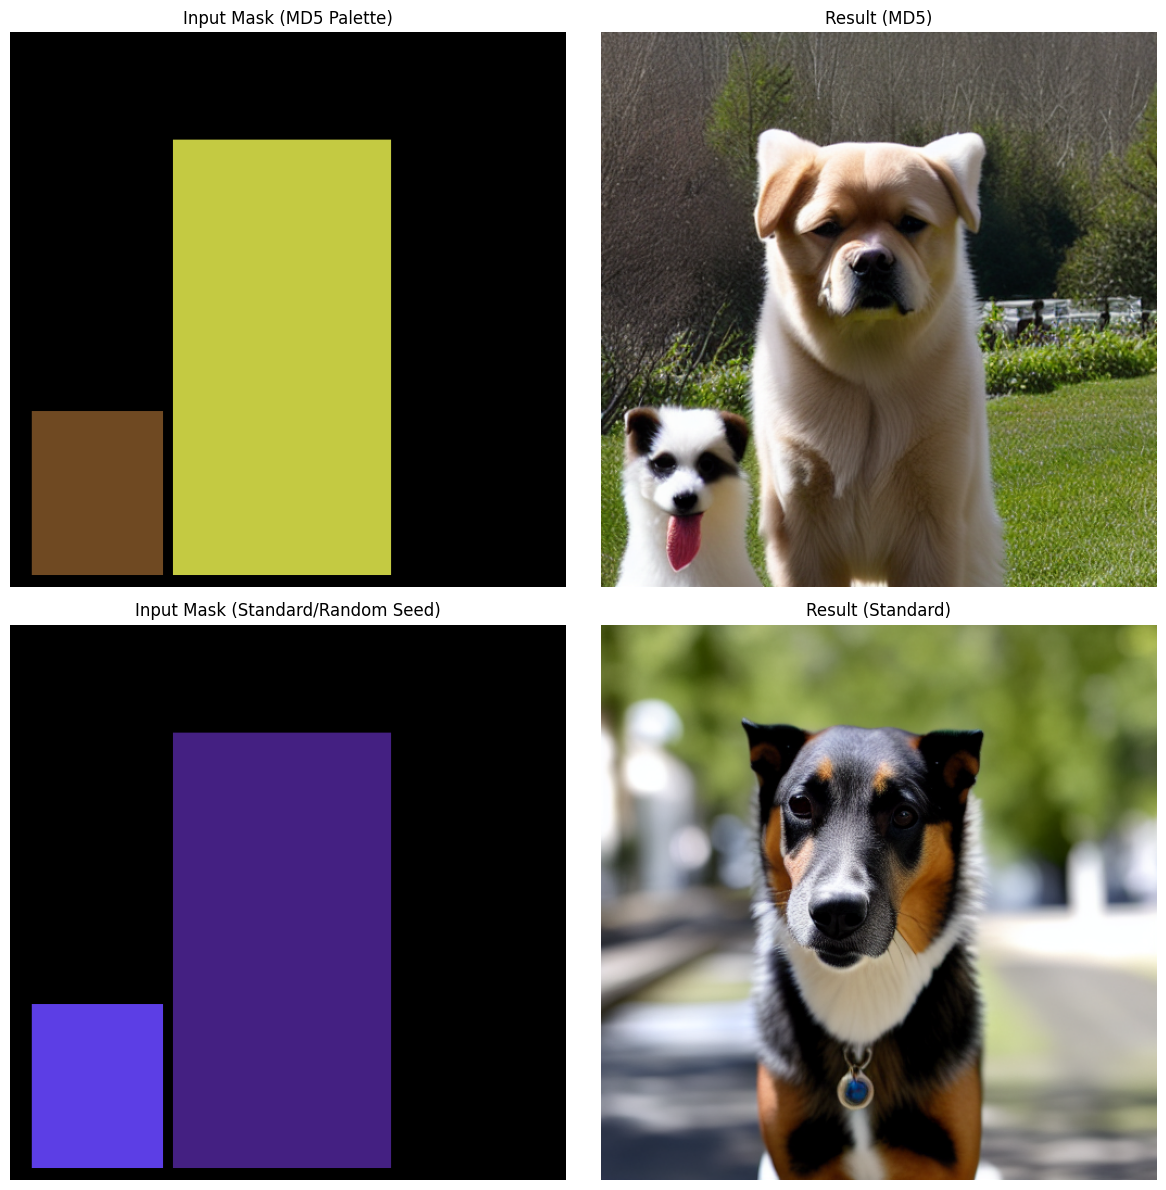

In [8]:
# import torch
# import numpy as np
# from PIL import Image, ImageDraw
# from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
# import hashlib
# import matplotlib.pyplot as plt

# # --- CONFIG ---
# MODEL_ID = "runwayml/stable-diffusion-v1-5"
# CONTROLNET_ID = "ritishshrirao/Controlnet_SD1.5_coco_segmentation"
# DEVICE = "cuda"
# DTYPE = torch.bfloat16

# # --- 1. DEFINE PALETTES ---

# def get_md5_color(category_id):
#     """Your current logic"""
#     h = hashlib.md5(str(category_id).encode()).hexdigest()
#     return (int(h[0:2], 16), int(h[2:4], 16), int(h[4:6], 16))

# def get_coco_standard_color(category_id):
#     """
#     Standard COCO visualization logic (approximate).
#     Many ControlNets expect this or the 'stuff' palette.
#     """
#     import random
#     random.seed(category_id)
#     return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

# # --- 2. CREATE SYNTHETIC MASKS ---

# def create_test_mask(color_func):
#     # 512x512 Black Background
#     mask = Image.new("RGB", (512, 512), (0, 0, 0))
#     draw = ImageDraw.Draw(mask)
    
#     # ID 1 = Person (Center, Large Rectangle)
#     person_color = color_func(1)
#     draw.rectangle([150, 100, 350, 500], fill=person_color)
    
#     # ID 18 = Dog (Bottom Left, Small Square)
#     dog_color = color_func(18)
#     draw.rectangle([20, 350, 140, 500], fill=dog_color)
    
#     return mask, person_color, dog_color

# # --- 3. LOAD MODEL ---
# print("⏳ Loading ControlNet & SD Pipeline...")
# controlnet = ControlNetModel.from_pretrained(CONTROLNET_ID, torch_dtype=DTYPE)
# pipe = StableDiffusionControlNetPipeline.from_pretrained(
#     MODEL_ID, controlnet=controlnet, torch_dtype=DTYPE
# ).to(DEVICE)

# # Faster scheduler
# pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# # Optimize
# pipe.enable_model_cpu_offload() 
# # pipe.enable_xformers_memory_efficient_attention()

# # --- 4. GENERATE ---

# prompt = "A photorealistic person standing next to a dog, 4k, high quality"
# negative_prompt = "cartoon, painting, low quality, distorted"

# # Test A: Your MD5 Logic
# mask_md5, c1, c2 = create_test_mask(get_md5_color)
# print(f"🎨 Testing MD5 Palette (Person Color: {c1})...")
# image_md5 = pipe(
#     prompt, 
#     image=mask_md5, 
#     negative_prompt=negative_prompt, 
#     num_inference_steps=20
# ).images[0]

# # Test B: Standard Logic
# mask_std, c1, c2 = create_test_mask(get_coco_standard_color)
# print(f"🎨 Testing Standard Palette (Person Color: {c1})...")
# image_std = pipe(
#     prompt, 
#     image=mask_std, 
#     negative_prompt=negative_prompt, 
#     num_inference_steps=20
# ).images[0]

# # --- 5. VISUALIZE RESULTS ---
# fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# axs[0, 0].imshow(mask_md5)
# axs[0, 0].set_title("Input Mask (MD5 Palette)")
# axs[0, 0].axis("off")

# axs[0, 1].imshow(image_md5)
# axs[0, 1].set_title("Result (MD5)")
# axs[0, 1].axis("off")

# axs[1, 0].imshow(mask_std)
# axs[1, 0].set_title("Input Mask (Standard/Random Seed)")
# axs[1, 0].axis("off")

# axs[1, 1].imshow(image_std)
# axs[1, 1].set_title("Result (Standard)")
# axs[1, 1].axis("off")

# plt.tight_layout()
# plt.show()

In [5]:
import kagglehub
import shutil
import os

# Define paths
DEST_DIR = "/mnt/coco/data"
TRAIN_DIR_TARGET = os.path.join(DEST_DIR, "train2017")
ANN_DIR_TARGET = os.path.join(DEST_DIR, "annotations")

def setup_data():
    # Check if data exists to avoid re-downloading
    if os.path.exists(TRAIN_DIR_TARGET) and os.path.exists(ANN_DIR_TARGET):
        print(f"✅ Data found in {DEST_DIR}. Skipping download.")
        return

    print("⬇️  Data not found in volume. Downloading via KaggleHub...")
    
    # Download dataset
    # This downloads to ~/.cache/kagglehub/...
    path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")
    print(f"✅ Downloaded to cache: {path}")

    # The dataset structure from this repo is usually: 
    # path/coco2017/train2017 and path/coco2017/annotations
    source_root = os.path.join(path, "coco2017")
    if not os.path.exists(source_root):
        source_root = path # Fallback if structure differs

    print(f"📦 Moving files to persistent volume: {DEST_DIR} ...")
    
    # Move Train Images
    src_train = os.path.join(source_root, "train2017")
    if os.path.exists(src_train):
        if os.path.exists(TRAIN_DIR_TARGET): shutil.rmtree(TRAIN_DIR_TARGET)
        shutil.move(src_train, TRAIN_DIR_TARGET)
        print("   -> Moved train2017")
    else:
        print(f"   ⚠️ Could not find train2017 in {source_root}")

    # Move Annotations
    src_ann = os.path.join(source_root, "annotations")
    if os.path.exists(src_ann):
        if os.path.exists(ANN_DIR_TARGET): shutil.rmtree(ANN_DIR_TARGET)
        shutil.move(src_ann, ANN_DIR_TARGET)
        print("   -> Moved annotations")
    else:
        print(f"   ⚠️ Could not find annotations in {source_root}")

    print("🎉 Data setup complete.")

if __name__ == "__main__":
    setup_data()

✅ Data found in /mnt/coco/data. Skipping download.


In [6]:
%%writefile train_video_seg.py
import os
import random
import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms.functional as TF
from PIL import Image
from tqdm.auto import tqdm
from pycocotools.coco import COCO
from torchvision import transforms
import wandb
import gc
import bitsandbytes as bnb

# Accelerate & Diffusers
from accelerate import Accelerator
from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    ControlNetModel,
    MotionAdapter,
    DDPMScheduler,
    AnimateDiffPipeline,
)
from transformers import AutoTokenizer, CLIPTextModel

# --- ENABLE TF32 ---
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# --- CONFIGURATION ---
class Config:
    # --- PATHS (Modal /mnt/coco structure) ---
    COCO_ROOT = "/mnt/coco/data"
    TRAIN_IMG_DIR = os.path.join(COCO_ROOT, "train2017")
    TRAIN_ANN_FILE = os.path.join(COCO_ROOT, "annotations/instances_train2017.json")
    
    OUTPUT_DIR = "/mnt/coco/models/animatediff_coco_finetune"
    
    # --- MODELS ---
    SD_MODEL_ID = "runwayml/stable-diffusion-v1-5"
    CONTROLNET_ID = "ritishshrirao/Controlnet_SD1.5_coco_segmentation"
    MOTION_ADAPTER_ID = "guoyww/animatediff-motion-adapter-v1-5-2"
    
    # --- HYPERPARAMETERS ---
    RESOLUTION = 512
    NUM_FRAMES = 8
    BATCH_SIZE = 4     
    GRAD_ACCUM_STEPS = 2
    LEARNING_RATE = 2e-5     
    NUM_EPOCHS = 10
    
    SAVE_INTERVAL = 500      
    LOG_VIDEO_INTERVAL = 10
    MAX_SAMPLES = 50000      
    NUM_WORKERS = 4
    
    # --- SYNTHETIC MOTION ---
    ZOOM_RANGE = (1.0, 1.15) 
    PAN_RANGE = 30           

# --- SYNTHETIC VIDEO DATASET ---
class COCOSyntheticVideoDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, ann_file, tokenizer, size=512, frames=16, max_samples=None):
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.img_ids = self.coco.getImgIds()
        self.tokenizer = tokenizer
        self.size = size
        self.frames = frames
        
        self.img_ids = [img_id for img_id in self.img_ids if len(self.coco.getAnnIds(imgIds=img_id)) > 0]
        if max_samples: self.img_ids = self.img_ids[:max_samples]
            
        self.color_map = self._generate_color_map()
        self.norm = transforms.Normalize([0.5], [0.5])

    def _generate_color_map(self):
        cats = self.coco.loadCats(self.coco.getCatIds())
        palette = {}
        for cat in cats:
            import hashlib
            h = hashlib.md5(str(cat['id']).encode()).hexdigest()
            palette[cat['id']] = (int(h[0:2], 16), int(h[2:4], 16), int(h[4:6], 16))
        return palette

    def draw_segmentation_map(self, img_shape, anns):
        mask = np.zeros((img_shape[1], img_shape[0], 3), dtype=np.uint8)
        anns = sorted(anns, key=lambda x: x['area'], reverse=True)
        for ann in anns:
            cat_id = ann['category_id']
            color = self.color_map.get(cat_id, (255, 255, 255))
            binary_mask = self.coco.annToMask(ann)
            mask[binary_mask == 1] = color
        return Image.fromarray(mask)

    def apply_synthetic_motion(self, img, seg_map):
        frames_img = []
        frames_seg = []
        mode = random.randint(0, 3)
        target_zoom = random.uniform(*Config.ZOOM_RANGE) if mode in [0, 3] else 1.0
        target_pan_x = random.uniform(0, Config.PAN_RANGE) if mode in [1, 3] else 0.0
        target_pan_y = random.uniform(0, Config.PAN_RANGE) if mode in [2, 3] else 0.0
        
        for i in range(self.frames):
            progress = i / max(1, (self.frames - 1))
            curr_zoom = 1.0 + (target_zoom - 1.0) * progress
            curr_tx, curr_ty = target_pan_x * progress, target_pan_y * progress
            
            def transform_frame(pil_img, is_mask):
                interp = TF.InterpolationMode.NEAREST if is_mask else TF.InterpolationMode.BILINEAR
                img_t = TF.affine(pil_img, angle=0, translate=(curr_tx, curr_ty), scale=curr_zoom, shear=0, interpolation=interp, fill=0)
                img_t = TF.resize(img_t, (self.size, self.size), interpolation=interp)
                tensor = TF.to_tensor(img_t)
                if not is_mask: tensor = self.norm(tensor)
                return tensor

            frames_img.append(transform_frame(img, False))
            frames_seg.append(transform_frame(seg_map, True))
            
        return torch.stack(frames_img), torch.stack(frames_seg)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        try:
            img_id = self.img_ids[idx]
            img_info = self.coco.loadImgs(img_id)[0]
            img_path = os.path.join(self.img_dir, img_info['file_name'])
            image = Image.open(img_path).convert("RGB")
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            anns = self.coco.loadAnns(ann_ids)
            control_image = self.draw_segmentation_map(image.size, anns)
            
            pixel_values, condition_values = self.apply_synthetic_motion(image, control_image)
            
            cat_names = list(set([cat['name'] for cat in self.coco.loadCats([ann['category_id'] for ann in anns])]))
            text_prompt = f"A photorealistic video of {', '.join(cat_names)}" if cat_names else "A photorealistic video"
            
            return {
                "pixel_values": pixel_values,
                "condition_values": condition_values,
                "input_ids": self.tokenizer(text_prompt, max_length=self.tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt").input_ids[0],
                "prompt_text": text_prompt
            }
        except Exception as e:
            print(f"Error on index {idx}: {e}")
            return self.__getitem__(random.randint(0, len(self)-1))

# --- VALIDATION ---
def log_validation(accelerator, unet, controlnet, vae, text_encoder, tokenizer, val_batch):
    if not accelerator.is_main_process: return
    print("Running Validation...")
    torch.cuda.empty_cache()

    unet_unwrapped = accelerator.unwrap_model(unet)
    controlnet_unwrapped = accelerator.unwrap_model(controlnet)

    pipeline = AnimateDiffPipeline.from_pretrained(
        Config.SD_MODEL_ID,
        unet=unet_unwrapped,
        controlnet=controlnet_unwrapped,
        vae=vae,
        text_encoder=text_encoder,
        tokenizer=tokenizer,
        torch_dtype=torch.bfloat16
    ).to(accelerator.device)
    pipeline.enable_vae_slicing()
    
    # Cast to BF16 for pipeline compatibility
    control_video = val_batch["condition_values"][0].unsqueeze(0).to(accelerator.device, dtype=torch.bfloat16)
    prompt = val_batch["prompt_text"][0]
    
    pil_controls = []
    for i in range(control_video.shape[1]):
        # !!! FIX: Convert BF16 to Float32 before sending to PIL !!!
        frame = control_video[0, i].float() 
        frame = transforms.ToPILImage()(frame)
        pil_controls.append(frame)

    generator = torch.Generator(device=accelerator.device).manual_seed(42)
    
    try:
        with torch.autocast("cuda", dtype=torch.bfloat16):
            output = pipeline(
                prompt=prompt,
                negative_prompt="bad quality",
                num_frames=Config.NUM_FRAMES,
                controlnet_conditioning_scale=1.0,
                control_image=pil_controls,
                num_inference_steps=20,
                generator=generator
            )
        frames = output.frames[0]
        combined_frames = []
        for i, frame in enumerate(frames):
            ctrl = pil_controls[i].resize(frame.size)
            new_img = Image.new('RGB', (frame.width * 2, frame.height))
            new_img.paste(ctrl, (0, 0))
            new_img.paste(frame, (frame.width, 0))
            combined_frames.append(np.array(new_img))
            
        combined_frames = np.stack(combined_frames).transpose(0, 3, 1, 2)
        wandb.log({"val_video": wandb.Video(combined_frames, fps=8, format="mp4", caption=prompt)})
    except Exception as e:
        print(f"Validation failed: {e}")
    
    del pipeline
    torch.cuda.empty_cache()
    gc.collect()

# --- MAIN ---
def main():
    accelerator = Accelerator(
        gradient_accumulation_steps=Config.GRAD_ACCUM_STEPS,
        mixed_precision="bf16",
        log_with="wandb",
    )
    
    if accelerator.is_main_process:
        os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
        config_dict = {k: v for k, v in Config.__dict__.items() if not k.startswith("__")}
        wandb.init(project="animatediff-coco-seg", config=config_dict)

    # Load Adapter & Pipeline
    adapter = MotionAdapter.from_pretrained(Config.MOTION_ADAPTER_ID)
    controlnet = ControlNetModel.from_pretrained(Config.CONTROLNET_ID)
    
    tmp_pipeline = AnimateDiffPipeline.from_pretrained(
        Config.SD_MODEL_ID,
        motion_adapter=adapter,
        controlnet=controlnet,
    )
    
    unet = tmp_pipeline.unet
    vae = tmp_pipeline.vae
    text_encoder = tmp_pipeline.text_encoder
    tokenizer = tmp_pipeline.tokenizer
    noise_scheduler = DDPMScheduler.from_pretrained(Config.SD_MODEL_ID, subfolder="scheduler")
    
    del tmp_pipeline

    # Freeze Base Models
    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)
    controlnet.requires_grad_(False)
    unet.requires_grad_(False)
    
    # 1. IDENTIFY & CAST TRAINABLE PARAMS
    motion_params = []
    for name, param in unet.named_parameters():
        if "motion_modules" in name:
            param.requires_grad = True
            motion_params.append(param)
            # Critical for Mixed Precision Training
            param.data = param.data.to(torch.float32)

    if not motion_params:
        raise ValueError("No motion parameters found!")

    # 2. GRADIENT CHECKPOINTING
    unet.enable_gradient_checkpointing()
    controlnet.enable_gradient_checkpointing()
    
    dataset = COCOSyntheticVideoDataset(Config.TRAIN_IMG_DIR, Config.TRAIN_ANN_FILE, tokenizer, size=Config.RESOLUTION, frames=Config.NUM_FRAMES, max_samples=Config.MAX_SAMPLES)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS)
    val_batch = next(iter(dataloader))

    # 3. 8-BIT OPTIMIZER
    optimizer = bnb.optim.AdamW8bit(motion_params, lr=Config.LEARNING_RATE)

    unet, optimizer, dataloader, controlnet = accelerator.prepare(unet, optimizer, dataloader, controlnet)
    
    # Cast frozen models to BF16
    vae.to(accelerator.device, dtype=torch.bfloat16)
    text_encoder.to(accelerator.device, dtype=torch.bfloat16)
    
    global_step = 0
    
    for epoch in range(Config.NUM_EPOCHS):
        unet.train()
        progress_bar = tqdm(total=len(dataloader), disable=not accelerator.is_local_main_process, desc=f"Epoch {epoch}")
        
        for batch in dataloader:
            with accelerator.accumulate(unet):
                pixel_values = batch["pixel_values"].to(dtype=torch.bfloat16)
                condition_values = batch["condition_values"].to(dtype=torch.bfloat16)
                input_ids = batch["input_ids"]
                
                b, f, c, h, w = pixel_values.shape
                
                # VAE
                pixel_values_reshaped = pixel_values.view(-1, c, h, w)
                latents = vae.encode(pixel_values_reshaped).latent_dist.sample()
                latents = latents * vae.config.scaling_factor
                latents = latents.view(b, f, -1, h // 8, w // 8).permute(0, 2, 1, 3, 4)
                
                # Noise
                noise = torch.randn_like(latents)
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (b,), device=latents.device).long()
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
                
                # CRITICAL: Manually enable grads on input tensor to allow checkpointing through frozen layers
                noisy_latents.requires_grad_(True)
                
                # Text
                encoder_hidden_states = text_encoder(input_ids)[0] 
                
                # ControlNet (Flattened B*F)
                noisy_latents_flat = noisy_latents.permute(0, 2, 1, 3, 4).reshape(b * f, -1, h // 8, w // 8)
                condition_flat = condition_values.view(b * f, c, h, w)
                
                encoder_hidden_states_rep = encoder_hidden_states.repeat_interleave(f, dim=0)
                timesteps_rep = timesteps.repeat_interleave(f)
                
                down_block_res, mid_block_res = controlnet(
                    noisy_latents_flat, 
                    timesteps_rep, 
                    encoder_hidden_states=encoder_hidden_states_rep, 
                    controlnet_cond=condition_flat, 
                    return_dict=False,
                )
                
                # UNet (5D)
                # We pass the original encoder_hidden_states_rep (expanded) to ensure shape match
                noise_pred = unet(
                    noisy_latents,                    
                    timesteps,  
                    encoder_hidden_states=encoder_hidden_states_rep, 
                    down_block_additional_residuals=[r.to(dtype=torch.bfloat16) for r in down_block_res],
                    mid_block_additional_residual=mid_block_res.to(dtype=torch.bfloat16)
                ).sample

                loss = torch.nn.functional.mse_loss(noise_pred.float(), noise.float())
                
                accelerator.backward(loss)
                optimizer.step()
                optimizer.zero_grad()
                
            if accelerator.sync_gradients:
                global_step += 1
                progress_bar.update(1)
                
                if accelerator.is_main_process:
                    wandb.log({"train_loss": loss.item()})
                    
                    if global_step % Config.LOG_VIDEO_INTERVAL == 0:
                        log_validation(accelerator, unet, controlnet, vae, text_encoder, tokenizer, val_batch)

                    if global_step % Config.SAVE_INTERVAL == 0:
                        save_path = os.path.join(Config.OUTPUT_DIR, f"checkpoint-{global_step}")
                        accelerator.unwrap_model(unet).save_motion_modules(save_path)

    if accelerator.is_main_process:
        print("Training Finished.")
        final_path = os.path.join(Config.OUTPUT_DIR, "final_motion_module")
        accelerator.unwrap_model(unet).save_motion_modules(final_path)
        accelerator.end_training()

if __name__ == "__main__":
    main()

Overwriting train_video_seg.py


In [ ]:
!accelerate launch \
    --num_processes=1 \
    --mixed_precision=bf16 \
    train_video_seg.py

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_machines` was set to a value of `1`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: Currently logged in as: ritishshrirao (ritishtest1) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: ⢿ Waiting for wandb.init()...
wandb: ⣻ setting up run rkkfvm43 (0.2s)
wandb: Tracking run with wandb version 0.23.1
wandb: Run data is saved locally in /root/wandb/run-20251215_162416-rkkfvm43
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run hearty-galaxy-20
wandb: ⭐️ View project at https://wandb.ai/ritishtest1/animatediff-coco-seg
wandb: 🚀 View run at https://wand

In [7]:
!accelerate launch \
    --multi_gpu \
    --num_processes=2 \
    --mixed_precision=fp16 \
    train_video_seg.py

Traceback (most recent call last):
  File "/usr/local/bin/accelerate", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/site-packages/accelerate/commands/accelerate_cli.py", line 50, in main
    args.func(args)
  File "/usr/local/lib/python3.12/site-packages/accelerate/commands/launch.py", line 1213, in launch_command
    args, defaults, mp_from_config_flag = _validate_launch_command(args)
                                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/accelerate/commands/launch.py", line 1033, in _validate_launch_command
    raise ValueError("You need to use at least 2 processes to use `--multi_gpu`.")
ValueError: You need to use at least 2 processes to use `--multi_gpu`.
